In [94]:
import numpy as np
import tensorflow.keras.backend as K
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Layer,Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Lambda
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Bidirectional, Flatten, SpatialDropout1D, add, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.activations import sigmoid
from sklearn.model_selection import KFold
import datetime
import sys
import os

from custom_model import Custom_Model

In [95]:
def DCNN_block(x, s, i, activation, nb_filters, kernel_size, dropout_rate=0, name=''):
    
    X_in = x 
    
    conv_1_1 = Conv1D(filters=nb_filters, data_format="channels_last", kernel_size=kernel_size,
                  dilation_rate=i, padding='causal')(X_in)
    conv_1_1 = BatchNormalization(trainable=True,axis=-1)(conv_1_1)
    conv_1_1 = Activation(activation)(conv_1_1)
    conv_1_1 = SpatialDropout1D(dropout_rate)(conv_1_1)
    
    conv_1_2 = Conv1D(filters=nb_filters, data_format="channels_last", kernel_size=kernel_size,
                  dilation_rate=i, padding='causal')(conv_1_1)
    conv_1_2 = BatchNormalization(trainable=True,axis=-1)(conv_1_2)
    conv_1_2 = Activation(activation)(conv_1_2)
    conv_1_2 = SpatialDropout1D(dropout_rate)(conv_1_2)
    
    attention_score = Lambda(sigmoid)(conv_1_2)
    X_out = Lambda(lambda x: tf.multiply(x[0], x[1]))([X_in, attention_score])
    
    return X_out

In [96]:
class MDCNN:
    def __init__(self,
                 nb_filters=64,
                 kernel_size=2,
                 nb_stacks=1,
                 dilations=None,
                 activation = "relu",
                 dropout_rate=0.1,
                 name='Multi-scale Dilated Convolutional Neural Network'):
        self.name = name
        self.activation = activation
        self.dropout_rate = dropout_rate
        self.dilations = dilations
        self.nb_stacks = nb_stacks
        self.kernel_size = kernel_size
        self.nb_filters = nb_filters

        if not isinstance(nb_filters, int):
            raise Exception()

    def __call__(self, inputs, mask=None):
        
        x = inputs
        X_0 = Conv1D(filters=self.nb_filters, kernel_size=1, dilation_rate=1, padding='causal')(x)
        multi_scale_connections = []
        
        X_out = X_0
        
        for s in range(self.nb_stacks):
            for i in [2 ** i for i in range(self.dilations)]:
                X_out = DCNN_block(X_out, s, i, self.activation,
                                                self.nb_filters,
                                                self.kernel_size, 
                                                self.dropout_rate,  
                                                name=self.name)
                
                multi_scale_connections.append(X_out)

        output = multi_scale_connections[0]
        for i, item in enumerate(multi_scale_connections):
            if i==0:
                continue
            output = K.concatenate([output, item],axis=-1)     

        return output

    
def smooth_labels(labels, factor=0.1):
    labels *= (1 - factor)
    labels += (factor / labels.shape[1])
    return labels
    
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex/K.sum(ex, axis=axis, keepdims=True)

In [97]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

class MDCNN_Model(Custom_Model):
    
    def __init__(self, args, input_shape, class_label, **params):
        super(MDCNN_Model, self).__init__(**params)
        self.args = args
        self.data_shape = input_shape
        self.num_classes = len(class_label)
        self.class_label = class_label
        print("MDCNN MODEL SHAPE:",input_shape)
    
    def create_model(self):
        
        self.inputs=Input(shape = (self.data_shape[0],self.data_shape[1]))
        self.output = MDCNN(nb_filters=self.args.filter_size,
                            kernel_size=self.args.kernel_size, 
                            nb_stacks=self.args.stack_size,
                            dilations=self.args.dilation_size,
                            dropout_rate=self.args.dropout,
                            activation = self.args.activation,
                            name='Multi-scale Dilated Convolutional Neural Network')(self.inputs)
         
        self.output = GlobalAveragePooling1D()(self.output)
        
        self.predictions = Dense(self.num_classes, activation='softmax')(self.output)
        self.model = Model(inputs = self.inputs, outputs = self.predictions)
        
        self.model.compile(loss = "categorical_crossentropy",
                           optimizer =Adam(learning_rate=self.args.lr, beta_1=self.args.beta1, beta_2=self.args.beta2, epsilon=1e-8),
                           metrics = ['accuracy'])
        
    def train(self, x, y):

        filepath = self.args.model_path
        if not os.path.exists(filepath):
            os.mkdir(filepath)
            
        i=1
        now = datetime.datetime.now()
        now_time = datetime.datetime.strftime(now,'%Y-%m-%d_%H-%M-%S')
        kfold = KFold(n_splits=self.args.split_fold, shuffle=True, random_state=self.args.random_seed)
        
        y_pred_all = []
        y_true_all = []
        avg_accuracy = 0
        self.history = []
        
        for train, test in kfold.split(x, y):
            self.create_model()
            y[train] = smooth_labels(y[train], 0.1)
            model_path = filepath + self.args.data + "_" + str(self.args.random_seed) + "_" + now_time
            if not os.path.exists(model_path):
                os.mkdir(model_path)
            weight_path = model_path + '/' + str(self.args.split_fold) + "-fold_weights_best_" + str(i) + ".hdf5"
            checkpoint = callbacks.ModelCheckpoint(weight_path, monitor='val_accuracy', verbose=1,save_weights_only=True,save_best_only=True,mode='max')
            print("Trainning fold {}".format(i))
            h = self.model.fit(x[train], y[train],validation_data=(x[test], y[test]),batch_size = self.args.batch_size, epochs = self.args.epoch, verbose=1, callbacks=[checkpoint])
            self.history.append(h)
            self.model.load_weights(weight_path)
            y_pred = self.model.predict(x[test])      
            y_pred = np.argmax(y_pred, axis=-1)
            y_true = np.argmax(y[test], axis=-1)
            y_pred_all.extend(y_pred)
            y_true_all.extend(y_true)
            avg_accuracy += accuracy_score(y_pred, y_true)
            print("Accuracy: {}".format(accuracy_score(y_pred, y_true)))
            i+=1
            
        print()
        unweighted_recall = recall_score(y_pred_all, y_true_all, average='macro')
        weighted_recall = recall_score(y_pred_all, y_true_all,  average='weighted')
        print("Average accuracy: {}".format(avg_accuracy / self.args.split_fold))
        print("Unweighted recall: {}".format(unweighted_recall))
        print("Weighted recall: {}".format(weighted_recall))

        K.clear_session()
        self.acc = avg_accuracy / self.args.split_fold
        self.uar = unweighted_recall
        self.war = weighted_recall
        self.trained = True
        
    def plot_confusion_matrix(self, conf_matrix):
        
        conf_matrix_percentage = np.zeros(shape=(self.num_classes, self.num_classes))
        for i in range(self.num_classes):
            for j in range(self.num_classes):
                conf_matrix_percentage[i][j] = conf_matrix[i][j] / np.sum(conf_matrix[i,:])
        conf_matrix_percentage = np.transpose(np.round(conf_matrix_percentage, 2))
        plt.figure(figsize=(8, 8))
        plt.matshow(conf_matrix, fignum=1, cmap="OrRd")
        plt.colorbar()
        for x in range(len(conf_matrix_percentage)):
            for y in range(len(conf_matrix_percentage)):
                plt.annotate(conf_matrix_percentage[x, y], xy=(x, y), horizontalalignment='center', verticalalignment='center') 
        plt.xticks(range(self.num_classes),self.class_label[:self.num_classes],color='black',fontsize=10, rotation=45)
        plt.yticks(range(self.num_classes),self.class_label[:self.num_classes],color='black',fontsize=10, rotation=45)
        plt.ylabel('True label', fontsize=16)
        plt.xlabel('Predicted label', labelpad=15, fontsize=16)
#         plt.savefig('confusion_matrix.png')
        plt.show() 
        
    def test(self, x, y, path):
        
        i=1
        kfold = KFold(n_splits=self.args.split_fold, shuffle=True, random_state=self.args.random_seed)
        
        y_pred_all = []
        y_true_all = []
        avg_accuracy = 0
        
        for train, test in kfold.split(x, y):
            self.create_model()
            weight_path = path + '/' + str(self.args.split_fold) + "-fold_weights_best_" + str(i) + ".hdf5"
            self.model.load_weights(weight_path)
            print("Predicting fold {}".format(i))
            y_pred = self.model.predict(x[test])      
            y_pred = np.argmax(y_pred, axis=-1)
            y_true = np.argmax(y[test], axis=-1)
            y_pred_all.extend(y_pred)
            y_true_all.extend(y_true)
            avg_accuracy += accuracy_score(y_pred, y_true)
            print("Accuracy: {}".format(accuracy_score(y_pred, y_true)))
            i+=1
        
        print()
        unweighted_recall = recall_score(y_pred_all, y_true_all, average='macro')
        weighted_recall = recall_score(y_pred_all, y_true_all,  average='weighted')
        cf = confusion_matrix(y_pred_all, y_true_all)
        print("Average accuracy: {}".format(avg_accuracy / self.args.split_fold))
        print("Unweighted recall: {}".format(unweighted_recall))
        print("Weighted recall: {}".format(weighted_recall))
        print()
        print(cf)
        self.plot_confusion_matrix(cf)

In [98]:
import argparse

parser = argparse.ArgumentParser()

parser.add_argument('--model_path', type=str, required=False, default='./Models/')
parser.add_argument('--test_path', type=str, required=False, default='./Test_Models/EMODB_46')
parser.add_argument('--data', type=str, required=False, default='RAVDESS')
parser.add_argument('--lr', type=float, required=False, default=0.001)
parser.add_argument('--beta1', type=float, required=False, default=0.93)
parser.add_argument('--beta2', type=float, required=False, default=0.98)
parser.add_argument('--batch_size', type=int, required=False, default=64)
parser.add_argument('--epoch', type=int, required=False, default=5)
parser.add_argument('--dropout', type=float, required=False, default=0.1)
parser.add_argument('--random_seed', type=int, required=False, default=46)
parser.add_argument('--activation', type=str, required=False, default='relu')
parser.add_argument('--filter_size', type=int, required=False, default=64)
parser.add_argument('--dilation_size', type=int, required=False, default=8)
parser.add_argument('--kernel_size', type=int, required=False, default=2)
parser.add_argument('--stack_size', type=int, required=False, default=1)
parser.add_argument('--split_fold', type=int, required=False, default=10)
parser.add_argument("-f", required=False)

args = parser.parse_args()

In [99]:
import pickle

data = np.load("clean_data.pickle",allow_pickle=True)

x_source = data["feature"]
y_source = data["emotion"]
z_source = data['gender']
x_source_male = [] 
x_source_female = []
y_source_male = []
y_source_female = []

##split the data into male-only and female-only halves 
for i in range(z_source.shape[0]):
    if z_source[i][0] == 1:
        x_source_female.append(x_source[i])
        y_source_female.append(y_source[i])
    else:
        x_source_male.append(x_source[i])
        y_source_male.append(y_source[i])
        
x_source_male = np.array(x_source_male)
y_source_male = np.array(y_source_male)
x_source_female = np.array(x_source_female)
y_source_female = np.array(y_source_female)

print(x_source.shape)
print(y_source.shape)
print(x_source_male.shape)
print(y_source_male.shape)
print(x_source_female.shape)
print(y_source_female.shape)
    
CLASS_LABELS = ('neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised')
model = MDCNN_Model(args=args, input_shape=x_source.shape[1:], class_label=CLASS_LABELS)

(1440, 215, 39)
(1440, 8)
(720, 215, 39)
(720, 8)
(720, 215, 39)
(720, 8)
MDCNN MODEL SHAPE: (215, 39)


Predicting fold 1
5/5 [==============================] - 1s 49ms/step
Accuracy: 0.875
Predicting fold 2
5/5 [==============================] - 1s 48ms/step
Accuracy: 0.9305555555555556
Predicting fold 3
5/5 [==============================] - 1s 49ms/step
Accuracy: 0.9166666666666666
Predicting fold 4
5/5 [==============================] - 1s 59ms/step
Accuracy: 0.8888888888888888
Predicting fold 5
5/5 [==============================] - 2s 52ms/step
Accuracy: 0.9097222222222222
Predicting fold 6
5/5 [==============================] - 1s 48ms/step
Accuracy: 0.9166666666666666
Predicting fold 7
5/5 [==============================] - 1s 56ms/step
Accuracy: 0.8819444444444444
Predicting fold 8
5/5 [==============================] - 1s 56ms/step
Accuracy: 0.9027777777777778
Predicting fold 9
5/5 [==============================] - 1s 112ms/step
Accuracy: 0.8541666666666666
Predicting fold 10
5/5 [==============================] - 2s 53ms/step
Accuracy: 0.9166666666666666

Average accuracy: 0.

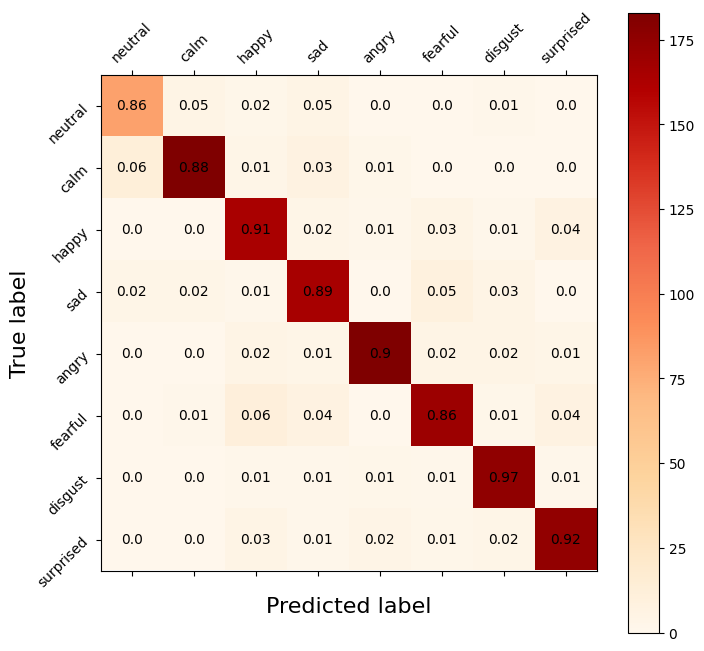

In [100]:
test_path = os.path.join(os.getcwd(), 'Models/clean-all')
model.test(x_source, y_source, test_path)

Predicting fold 1
3/3 [==============================] - 2s 77ms/step
Accuracy: 0.9444444444444444
Predicting fold 2
3/3 [==============================] - 1s 46ms/step
Accuracy: 0.875
Predicting fold 3
3/3 [==============================] - 1s 35ms/step
Accuracy: 0.9444444444444444
Predicting fold 4
3/3 [==============================] - 2s 70ms/step
Accuracy: 0.875
Predicting fold 5
3/3 [==============================] - 1s 43ms/step
Accuracy: 0.8472222222222222
Predicting fold 6
3/3 [==============================] - 2s 60ms/step
Accuracy: 0.9166666666666666
Predicting fold 7
3/3 [==============================] - 1s 45ms/step
Accuracy: 0.9166666666666666
Predicting fold 8
3/3 [==============================] - 1s 43ms/step
Accuracy: 0.9027777777777778
Predicting fold 9
3/3 [==============================] - 1s 39ms/step
Accuracy: 0.9027777777777778
Predicting fold 10
3/3 [==============================] - 1s 33ms/step
Accuracy: 0.8888888888888888

Average accuracy: 0.90138888888888

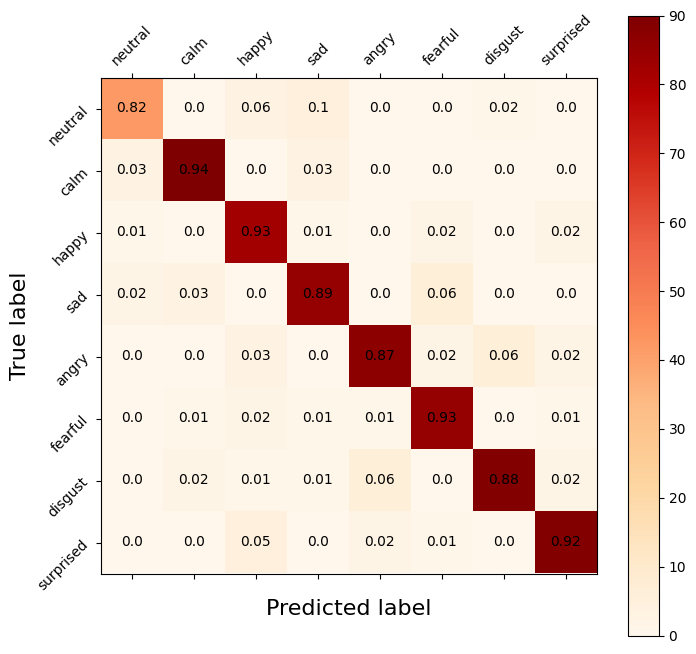

In [101]:
test_path = os.path.join(os.getcwd(), 'Models/clean-female')
model.test(x_source_female, y_source_female, test_path)

Predicting fold 1
3/3 [==============================] - 1s 44ms/step
Accuracy: 0.8888888888888888
Predicting fold 2
3/3 [==============================] - 2s 58ms/step
Accuracy: 0.875
Predicting fold 3
3/3 [==============================] - 20s 46ms/step
Accuracy: 0.9583333333333334
Predicting fold 4
3/3 [==============================] - 1s 46ms/step
Accuracy: 0.9166666666666666
Predicting fold 5
3/3 [==============================] - 1s 51ms/step
Accuracy: 0.8611111111111112
Predicting fold 6
3/3 [==============================] - 2s 46ms/step
Accuracy: 0.8611111111111112
Predicting fold 7
3/3 [==============================] - 1s 75ms/step
Accuracy: 0.8472222222222222
Predicting fold 8
3/3 [==============================] - 1s 37ms/step
Accuracy: 0.9444444444444444
Predicting fold 9
3/3 [==============================] - 1s 66ms/step
Accuracy: 0.7638888888888888
Predicting fold 10
3/3 [==============================] - 1s 40ms/step
Accuracy: 0.8055555555555556

Average accuracy: 0.

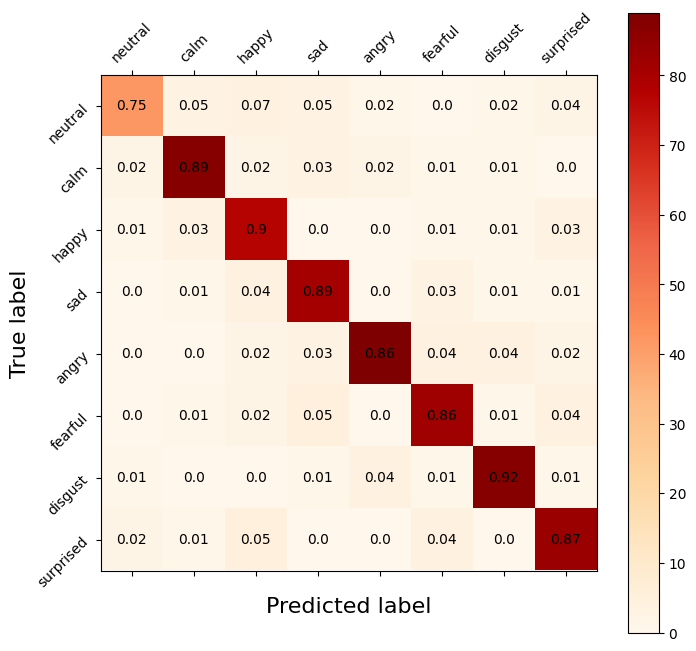

In [102]:
test_path = os.path.join(os.getcwd(), 'Models/clean-male')
model.test(x_source_male, y_source_male, test_path)

In [103]:
import pickle

data = np.load("noise_data.pickle",allow_pickle=True)

x_source = data["feature"]
y_source = data["emotion"]
z_source = data['gender']
x_source_male = [] 
x_source_female = []
y_source_male = []
y_source_female = []

##split the data into male-only and female-only halves 
for i in range(z_source.shape[0]):
    if z_source[i][0] == 1:
        x_source_female.append(x_source[i])
        y_source_female.append(y_source[i])
    else:
        x_source_male.append(x_source[i])
        y_source_male.append(y_source[i])
        
x_source_male = np.array(x_source_male)
y_source_male = np.array(y_source_male)
x_source_female = np.array(x_source_female)
y_source_female = np.array(y_source_female)

print(x_source.shape)
print(y_source.shape)
print(x_source_male.shape)
print(y_source_male.shape)
print(x_source_female.shape)
print(y_source_female.shape)

(1536, 215, 39)
(1536, 8)
(768, 215, 39)
(768, 8)
(768, 215, 39)
(768, 8)


Predicting fold 1
5/5 [==============================] - 2s 71ms/step
Accuracy: 0.9285714285714286
Predicting fold 2
5/5 [==============================] - 1s 49ms/step
Accuracy: 0.922077922077922
Predicting fold 3
5/5 [==============================] - 1s 43ms/step
Accuracy: 0.9415584415584416
Predicting fold 4
5/5 [==============================] - 1s 53ms/step
Accuracy: 0.9415584415584416
Predicting fold 5
5/5 [==============================] - 2s 61ms/step
Accuracy: 0.948051948051948
Predicting fold 6
5/5 [==============================] - 1s 46ms/step
Accuracy: 0.935064935064935
Predicting fold 7
5/5 [==============================] - 1s 47ms/step
Accuracy: 0.9150326797385621
Predicting fold 8
5/5 [==============================] - 1s 53ms/step
Accuracy: 0.9019607843137255
Predicting fold 9
5/5 [==============================] - 1s 46ms/step
Accuracy: 0.9084967320261438
Predicting fold 10
5/5 [==============================] - 1s 44ms/step
Accuracy: 0.9019607843137255

Average acc

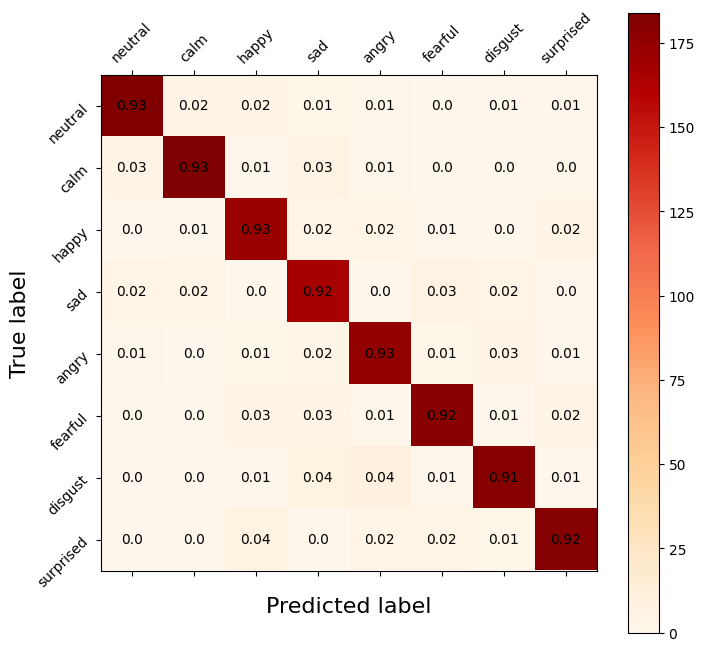

In [104]:
test_path = os.path.join(os.getcwd(), 'Models/noise-all')
model.test(x_source, y_source, test_path)

Predicting fold 1
3/3 [==============================] - 1s 40ms/step
Accuracy: 0.961038961038961
Predicting fold 2
3/3 [==============================] - 1s 45ms/step
Accuracy: 0.922077922077922
Predicting fold 3
3/3 [==============================] - 2s 46ms/step
Accuracy: 0.961038961038961
Predicting fold 4
3/3 [==============================] - 1s 55ms/step
Accuracy: 0.961038961038961
Predicting fold 5
3/3 [==============================] - 1s 47ms/step
Accuracy: 0.922077922077922
Predicting fold 6
3/3 [==============================] - 1s 42ms/step
Accuracy: 0.935064935064935
Predicting fold 7
3/3 [==============================] - 1s 51ms/step
Accuracy: 0.9090909090909091
Predicting fold 8
3/3 [==============================] - 1s 52ms/step
Accuracy: 0.9090909090909091
Predicting fold 9
3/3 [==============================] - 1s 48ms/step
Accuracy: 0.9605263157894737
Predicting fold 10
3/3 [==============================] - 1s 48ms/step
Accuracy: 0.9605263157894737

Average accura

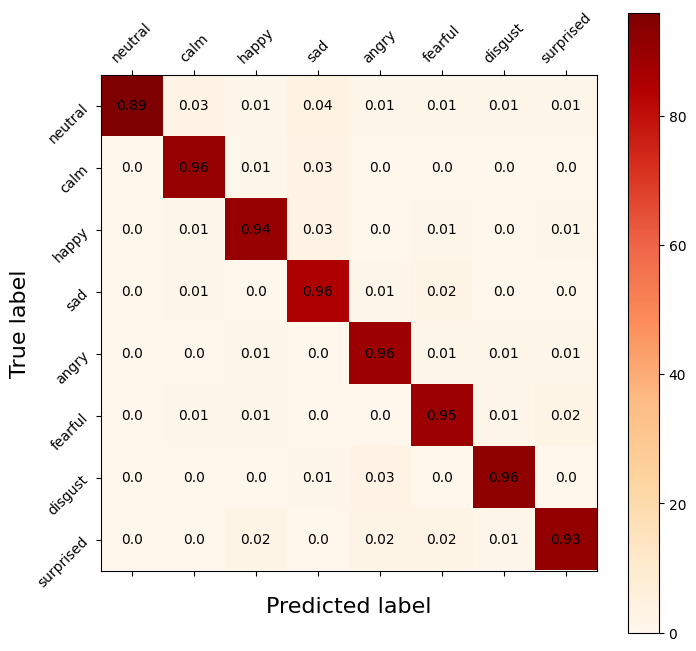

In [105]:
test_path = os.path.join(os.getcwd(), 'Models/noise-female')
model.test(x_source_female, y_source_female, test_path)

Predicting fold 1
3/3 [==============================] - 1s 62ms/step
Accuracy: 0.9090909090909091
Predicting fold 2
3/3 [==============================] - 2s 81ms/step
Accuracy: 0.922077922077922
Predicting fold 3
3/3 [==============================] - 1s 48ms/step
Accuracy: 0.9090909090909091
Predicting fold 4
3/3 [==============================] - 1s 85ms/step
Accuracy: 0.948051948051948
Predicting fold 5
3/3 [==============================] - 1s 55ms/step
Accuracy: 0.8831168831168831
Predicting fold 6
3/3 [==============================] - 2s 59ms/step
Accuracy: 0.8831168831168831
Predicting fold 7
3/3 [==============================] - 1s 48ms/step
Accuracy: 0.935064935064935
Predicting fold 8
3/3 [==============================] - 1s 51ms/step
Accuracy: 0.8831168831168831
Predicting fold 9
3/3 [==============================] - 1s 49ms/step
Accuracy: 0.9736842105263158
Predicting fold 10
3/3 [==============================] - 1s 53ms/step
Accuracy: 0.8947368421052632

Average acc

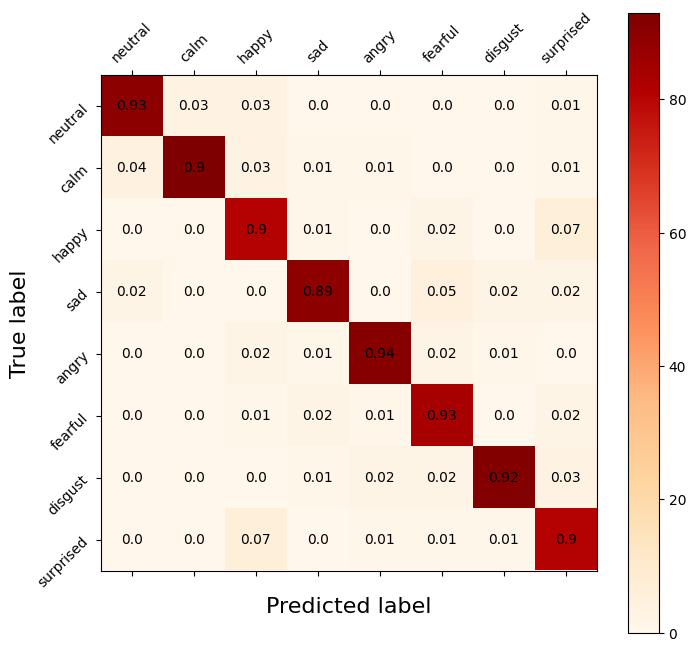

In [106]:
test_path = os.path.join(os.getcwd(), 'Models/noise-male')
model.test(x_source_male, y_source_male, test_path)